# Imports

In [1]:
import ete3
from urllib.request import urlopen
import xmltodict
import pandas as pd
import os
import seaborn as sns
from Bio import SeqIO
import collections
import matplotlib.pyplot as plt
import numpy as np
import dendropy
import time
import subprocess
%matplotlib inline

# Define helper functions for plotting and decorating the trees 

In [2]:
datapath = "../../Data"
tmppath = "."

In [3]:
def decorate(tree, bayes=False, prot=False):
    for leaf in tree:
        s = leaf.name.split('_')[1]
        if bayes:
            pID = leaf.name
        else:
            try:
                pID = leaf.name.split('|')[2]
            except:
                pID = leaf.name
        x= uniprot_meta(pID)
        taxa = x['uniprot']['entry']['organism']['lineage']['taxon']
        if s in metadata:
            n = metadata[s]
        else:
            n = taxa[0][0] + '|' + taxa[-1]
        k = n.split('|')[0]
        leaf.kingdom= k 
        
        leaf.protid = pID
        leaf.specID = s
        if '#text' not in x['uniprot']['entry']['organism']['name']:
            try:
                leaf.specie  = x['uniprot']['entry']['organism']['name'][0]['#text']
            except:
                print(x['uniprot']['entry']['organism']['name'])
        else:
            leaf.specie  = x['uniprot']['entry']['organism']['name']['#text']
        if 'recommendedName' in x['uniprot']['entry']['protein']:
            leaf.fullname = x['uniprot']['entry']['protein']['recommendedName']['fullName']['#text']
            leaf.shortname = x['uniprot']['entry']['protein']['recommendedName']['shortName']['#text']
        else:
            if len(x['uniprot']['entry']['protein']['submittedName']) != 1 and 'ecNumber' not in x['uniprot']['entry']['protein']['submittedName']:
                best= 0
                best_i = 0
                for i in range(len(x['uniprot']['entry']['protein']['submittedName'])):
                    e = int(x['uniprot']['entry']['protein']['submittedName'][i]['fullName']['@evidence'])
                    if e > best:
                        best = e
                        best_i = i
                leaf.fullname = x['uniprot']['entry']['protein']['submittedName'][best_i]['fullName']['#text']
                leaf.shortname = None
            else:
                leaf.fullname = x['uniprot']['entry']['protein']['submittedName']['fullName']['#text']
                leaf.shortname = None
        if 'Arthropoda' in taxa:
            k = 'Ar'
            leaf.kingdom=k
        nstyle = ete3.NodeStyle()
        if k == 'E':
            nstyle["fgcolor"] = "#55a868"
            nstyle["size"] = 15
        elif k == 'Ar':
            features = ''
            if 'feature' in x['uniprot']['entry']:
                feature = x['uniprot']['entry']['feature']            
                if type(feature) != collections.OrderedDict:
                    for i in feature:
                        if i['@type'] == 'domain':
                            features += i['@description'].lower()
                else:
                    if feature['@type'] == 'domain':
                        features = feature['@description'].lower()
            if 'osk' in leaf.fullname.lower():
                k = 'O'
            elif 'osk' in features:
                k = 'O'
            elif Test_Oskar(pID):
                k = 'O'
            if k == 'O':
                nstyle["fgcolor"] = "#8172b2"
                nstyle["size"] = 16
            else:
                nstyle["fgcolor"] = "#c44e52"
                nstyle["size"] = 15
            leaf.kingdom=k
        elif k == 'B':
            nstyle["fgcolor"] = "#4c72b0"
            nstyle["size"] = 15
        else:
            k = 'U'
            nstyle["fgcolor"] = "#ccb974"
            nstyle["size"] = 15
        leaf.set_style(nstyle)
        if leaf.shortname:
            n = leaf.shortname
        else:
            n = leaf.fullname
            if prot:
                leaf.name  =' '.join(leaf.specie.split(' ')[:2]) + ' - ' + n 
            else:
                if leaf.kingdom in ['B','A','U']:
                    leaf.name  =' '.join(leaf.specie.split(' ')[:4])
                else:
                    leaf.name  =' '.join(leaf.specie.split(' ')[:2])
    return tree
            
def uniprot_meta(accID):
    if not os.path.isdir(os.path.join(tmppath, 'uniprots')):
        os.mkdir(os.path.join(tmppath, 'uniprots'))
    uniprot_path = os.path.join(tmppath, 'uniprots', '{}.xml'.format(accID))
    if not os.path.isfile(uniprot_path):
        print("Downloading ", accID)
        url = "http://www.uniprot.org/uniprot/{}.xml".format(accID)
        with urlopen(url) as response:
            xml = response.read()
        handle = urlopen(url)
        xml = handle.read().decode()
        f = open(uniprot_path,'w')
        f.write(xml)
        f.close()
    else:
        xml = open(uniprot_path).read()
    xml = xmltodict.parse(xml)
    return xml

def Parse_HMMER_output(path):
    f = open(path)
    lines = f.readlines()
    f.close()
    collumns = ['target name', 'Prot_ID', 'Specie_ID', 'accession', 'query name', 'accession', 'Pre E-value', 'Pre score', 'Pre bias', 'E-value', 'score', 'bias', 'exp', 'reg', 'clu', 'ov', 'env', 'dom', 'rep', 'inc', 'description of target']
    res = []
    for line in lines:
        if line[0] != '#':
            s = [i for i in line.split(' ') if i]
            s = [s[0]] + [s[0].split('|')[2]] + [s[0].split('|')[2].split('_')[1]] + s[1:18] + [' '.join(s[18:])]
            res.append(s)
    df = pd.DataFrame(res, columns=collumns)
    return df

def Test_Oskar(accID):
    print("Testing if oskar")
    exist = False
    if accID not in uniprot_dl:
        if not os.path.isdir(os.path.join(tmppath, 'tmp')):
            os.mkdir(os.path.join(tmppath, 'tmp'))
        if not os.path.isfile(os.path.join(tmppath, 'tmp', '{}.fasta'.format(accID))):
            url = "http://www.uniprot.org/uniprot/%s.fasta" % (accID)
            with urlopen(url) as response:
                fasta = response.read()
            f = open(os.path.join(tmppath, 'tmp', '{}.fasta'.format(accID)), 'w')
            f.write(fasta.decode('utf-8'))
            f.close()
            handle = SeqIO.parse(os.path.join(tmppath, 'tmp', '{}.fasta'.format(accID)), 'fasta')
            try:
                for i in handle:
                    seq = i
                if i:
                    exist = True
                else:
                    exist = False
                uniprot_dl.append(accID)
            except:
                print(accID)
        else:
            exist = True
    else:
        exist = True
    if exist:
        out = subprocess.check_output(['hmmsearch',
                   '--cpu',
                   '7',
                   '-o',
                   'log_lotus',
                   '--tblout',
                   os.path.join(tmppath, 'tmp' ,'test_oskar_lotus.out'),
                   os.path.join(datapath, 'HMM','LOTUS.hmm'),
                   os.path.join(tmppath, 'tmp', '{}.fasta'.format(accID))]
                  )
        out = subprocess.check_output(['hmmsearch',
                           '--cpu',
                           '7',
                           '-o',
                           'log_osk',
                           '--tblout',
                           os.path.join(tmppath, 'tmp' ,'test_oskar_osk.out'),
                           os.path.join(datapath, 'HMM','OSK.hmm'),
                           os.path.join(tmppath, 'tmp', '{}.fasta'.format(accID))]
                          )
#         time.sleep(1)
        lotus = Parse_HMMER_output(os.path.join(tmppath, 'tmp' ,'test_oskar_lotus.out'))
        sgnh = Parse_HMMER_output(os.path.join(tmppath, 'tmp' ,'test_oskar_osk.out'))
        if len(sgnh) > 0 and len(lotus) == 0:
            f = open(os.path.join(tmppath, 'tmp' ,'toCheck'), 'a')
            f.write(accID + '\n')
        if len(lotus) > 0:
            if len(sgnh) > 0:
                return True
    return False

def Collapse_support(s, tree):
    a = tree.traverse()
    for i in a:
        if not i.name:
            if i.support < s:
                anc = i.get_ancestors()
                child = i.children
                if len(anc) > 0:
                    for c in child:
                        anc[-1].add_child(c)
                        i.detach()
                        
def remove_duplicate_specie(tree, ar=False):
    done = []
    for leaf in tree:
        if leaf.specID in done:
            if ar:
                if leaf.kingdom == 'Ar':
                    leaf.delete()
            else:
                leaf.delete()
        else:
            done.append(leaf.specID)
            
def DL_seq(accID, name):
    print("Doing ", accID)
    url = "http://www.uniprot.org/uniprot/%s.fasta" % (accID)
#     handle = urllib2.urlopen(url)
    with urlopen(url) as response:
        fasta = response.read()
    try:
        if fasta[0] == '>':
            f = open('./tmp/%s.fasta'%name, 'a')
            f.write(fasta)
            f.close()
    except:
        print("ERROR: ",accID)

# Define paths

In [4]:
taxonomy = os.path.join(datapath, "Taxonomy", "uniprot_ID_taxa.tsv")

#RAXML TREES
LOTUS_animala_path = os.path.join(datapath, 'Trees', 'LOTUS.raxml.bipartitions')
SGNH_RaxML_noPut_path = os.path.join(datapath, 'Trees', 'OSK.raxml.bipartitions')

#Mr BAYES TREES
LOTUS_animala_Bayes_path = os.path.join(datapath, 'Trees', 'LOTUS.bayes.nexus.con.tre')
SGNH_Bayes_noPut_path = os.path.join(datapath, 'Trees', 'OSK.bayes.nexus.con.tre')
                                    
# SOWHAT Best Trees
OSK_kingdom_sowhat = os.path.join(datapath, 'Trees', 'SOWHAT_kingdom_test.tre')
OSK_eukmono_sowhat = os.path.join(datapath, 'Trees', 'SOWHAT_eukmono_test.tre')

## Reading the metadata and loading the trees in a format compatible with ETE3

In [5]:
metadata = {}
f = open(taxonomy)
lines = f.readlines()
for i in range(len(lines)):
    line = lines[i].strip()
    s = line.split('\t')
    spec = s[2].split(',')[-1]
    kingdom = s[2].split(',')[0]
    acc = s[0]
    metadata[acc] = kingdom[0] + '|' + spec
uniprot_dl = []

In [6]:
data = dendropy.DataSet.get_from_path(LOTUS_animala_Bayes_path, "nexus")
data.write_to_path(LOTUS_animala_Bayes_path+ ".xml", "nexml")
LOTUS_animala_Bayes_path = LOTUS_animala_Bayes_path + '.xml'

data = dendropy.DataSet.get_from_path(SGNH_Bayes_noPut_path, "nexus")
data.write_to_path(SGNH_Bayes_noPut_path+ ".xml", "nexml")
SGNH_Bayes_noPut_path = SGNH_Bayes_noPut_path+ ".xml"



# Tree Plotting 

## Define the style parameters for the trees of Figure 2

In [7]:
ts = ete3.TreeStyle()
ts.mode = "c"
ts.arc_span = 180
ts.arc_start = -180
ts.scale = 70
ts.draw_guiding_lines = True
ts.optimal_scale_level = 'mid'
ts.show_branch_support = False
ts.show_scale = False
ts.show_leaf_name = True
ts.complete_branch_lines_when_necessary = True

# LOTUS Bayes Tree Circular for Figure 2

## Creating the tree and decorating it

In [8]:
nexml_project = ete3.Nexml()
nexml_project.build_from_file(LOTUS_animala_Bayes_path)
otu2name = {}
for taxa in  nexml_project.get_otus():
    for otu in taxa.get_otu():
        otu2name[otu.id] = otu.label.replace(' ','_')
        
tree_collections = nexml_project.get_trees()
collection_1 = tree_collections[0]
LOTUS_bayes = collection_1.get_tree()[0]
    # trees contain all the nexml information in their "nexml_node",
    # "nexml_tree", and "nexml_edge" attributes.

for node in LOTUS_bayes.traverse():
    if node.nexml_node.otu:
        node.name = otu2name[node.nexml_node.otu]
    for l in node.nexml_node.meta:
        if l.property == 'dendropy:prob(percent)':
            node.support = l.content

new = LOTUS_bayes.write('test.newick')
LOTUS_bayes = ete3.Tree(new)
LOTUS_bayes = decorate(LOTUS_bayes, bayes=True, prot=True)

trav = LOTUS_bayes.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2
for leaf in LOTUS_bayes:
    if leaf.kingdom == 'B':
        LOTUS_bayes.set_outgroup( leaf )
    n = leaf.name
    prot= n.split(' - ')[1]
    if 'tudor' in prot.lower():
        if '5' in prot:
            prot = 'Tud5'
        elif '7' in prot:
            prot = 'Tud7'
        else:
            prot = 'Tud?'
    elif leaf.kingdom == 'O':
        prot = 'Oskar'
    else:
        prot = 'Ukn'
    leaf.name = '  ' + leaf.name.split(' - ')[0] + ' - ' + prot

Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar


## Plotting the tree

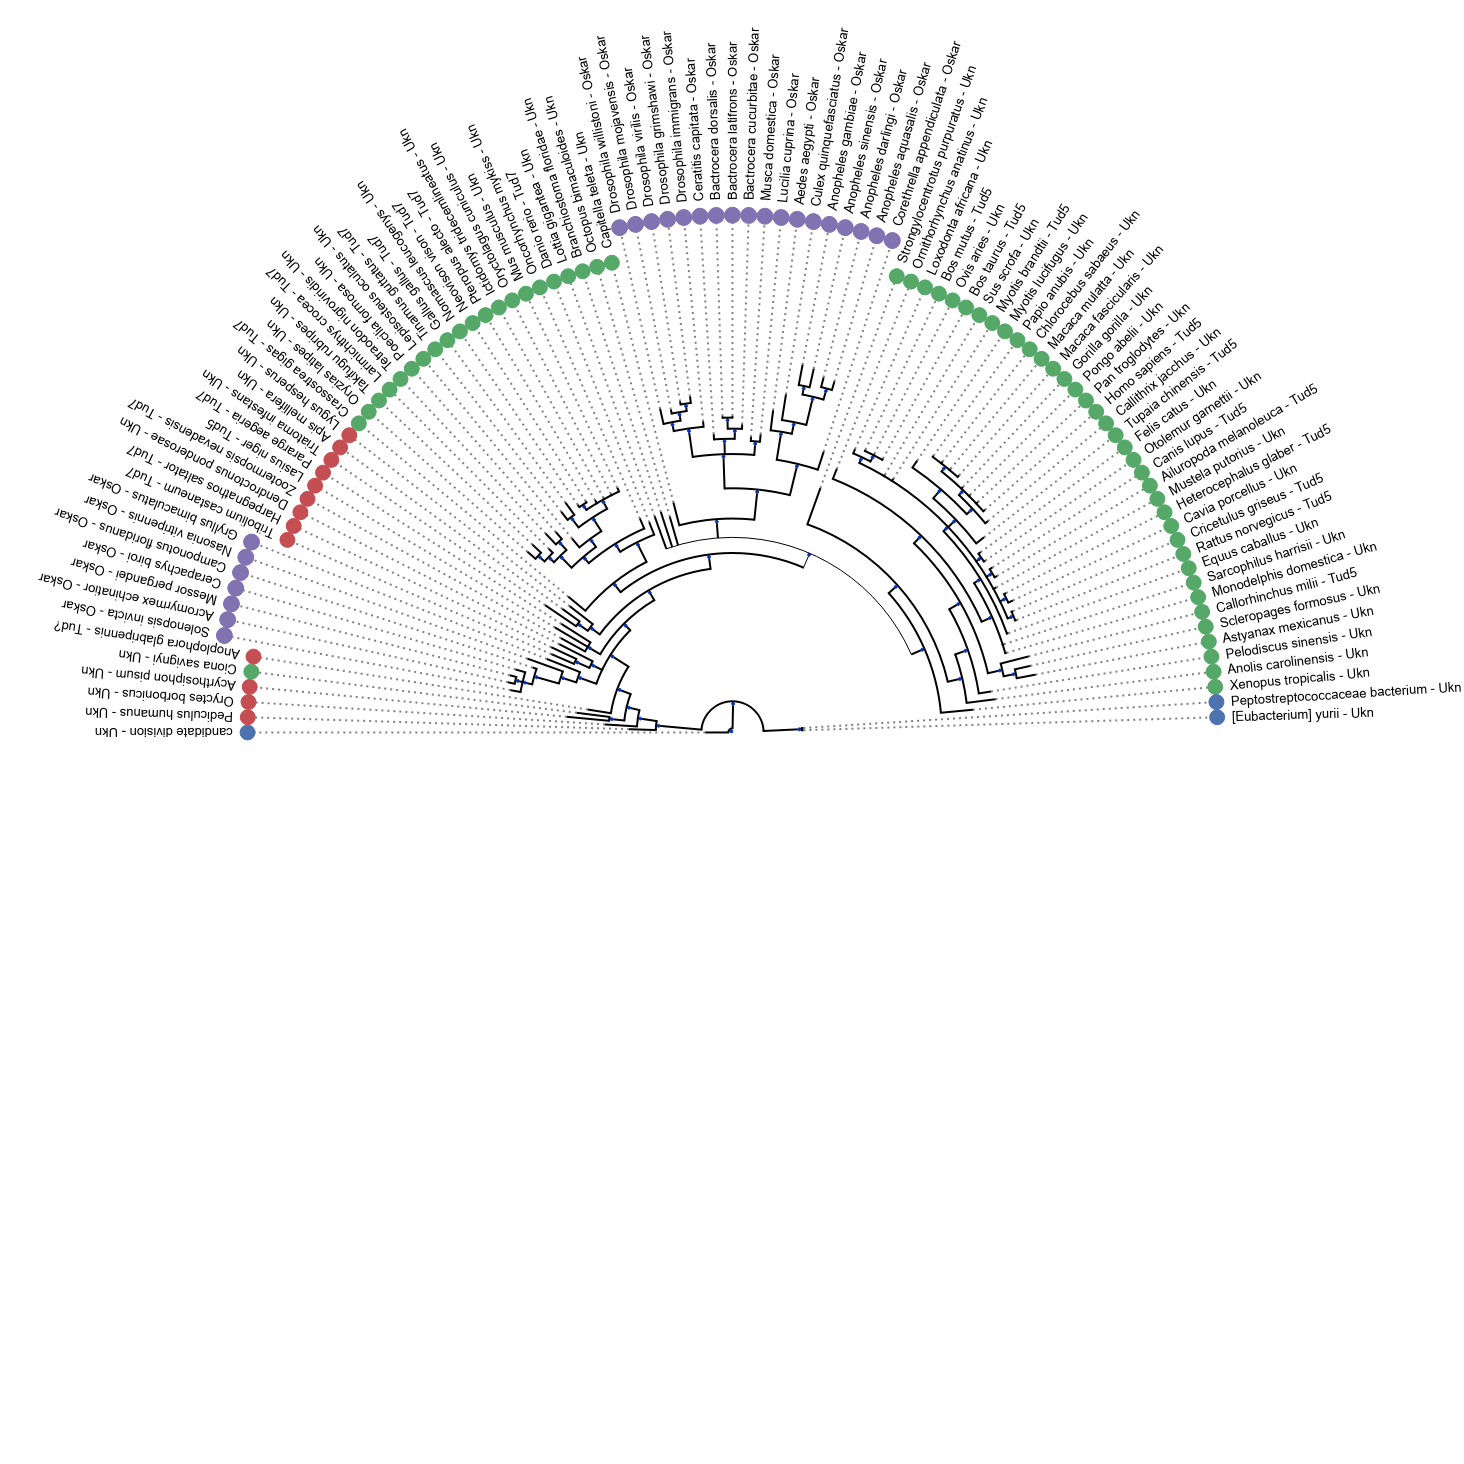

In [9]:
LOTUS_bayes.render('%%inline', tree_style=ts)
# LOTUS_bayes.render('Figure2_Lotus_Bayes_circular.pdf', tree_style=ts, units='mm', w=183, dpi=600)

# OSK Bayes Tree Circular for Figure 2

## Creating the tree and decorating it

In [106]:
nexml_project = ete3.Nexml()
nexml_project.build_from_file(SGNH_Bayes_noPut_path)
otu2name = {}
for taxa in  nexml_project.get_otus():
    for otu in taxa.get_otu():
        otu2name[otu.id] = otu.label.replace(' ','_')
        
tree_collections = nexml_project.get_trees()
collection_1 = tree_collections[0]
SGNH_Bayes_noPut = collection_1.get_tree()[0]
    # trees contain all the nexml information in their "nexml_node",
    # "nexml_tree", and "nexml_edge" attributes.

for node in SGNH_Bayes_noPut.traverse():
    if node.nexml_node.otu:
        node.name = otu2name[node.nexml_node.otu]
    for l in node.nexml_node.meta:
        if l.property == 'dendropy:prob(percent)':
            node.support = l.content
new = SGNH_Bayes_noPut.write('test.newick')

SGNH_Bayes_noPut = ete3.Tree(new)
SGNH_Bayes_noPut = decorate(SGNH_Bayes_noPut, bayes=True)

trav = SGNH_Bayes_noPut.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2
for leaf in SGNH_Bayes_noPut:
    leaf.name = '  ' + leaf.name + '  '
    if 'Methano' in leaf.name:
        print(leaf)
        SGNH_Bayes_noPut.set_outgroup( leaf )
    if leaf.kingdom == 'Ar':
        leaf.detach()
        
for node in SGNH_Bayes_noPut.traverse():
    if 'drosophila' in node.name.lower():
        node1 = node
    if 'firmicute' in node.name.lower():
        node2 = node
    if 'arcobacter' in node.name.lower():
        node3 = node
    if 'mycel' in node.name.lower():
        node4 = node
todetach = SGNH_Bayes_noPut.get_common_ancestor(node3, node4)
toattach = SGNH_Bayes_noPut.get_common_ancestor(node1, node3)
nodes = todetach.detach()
toattach.add_child(nodes)

Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar

--  Methanosarcina barkeri str. Wiesmoor  

--  Methanosarcina barkeri CM1  


Tree node '' (0x7f7ec8f3eb7)

## Reversing the tree to plot a circle

In [107]:
ts.arc_start = 0 

## Plotting the tree

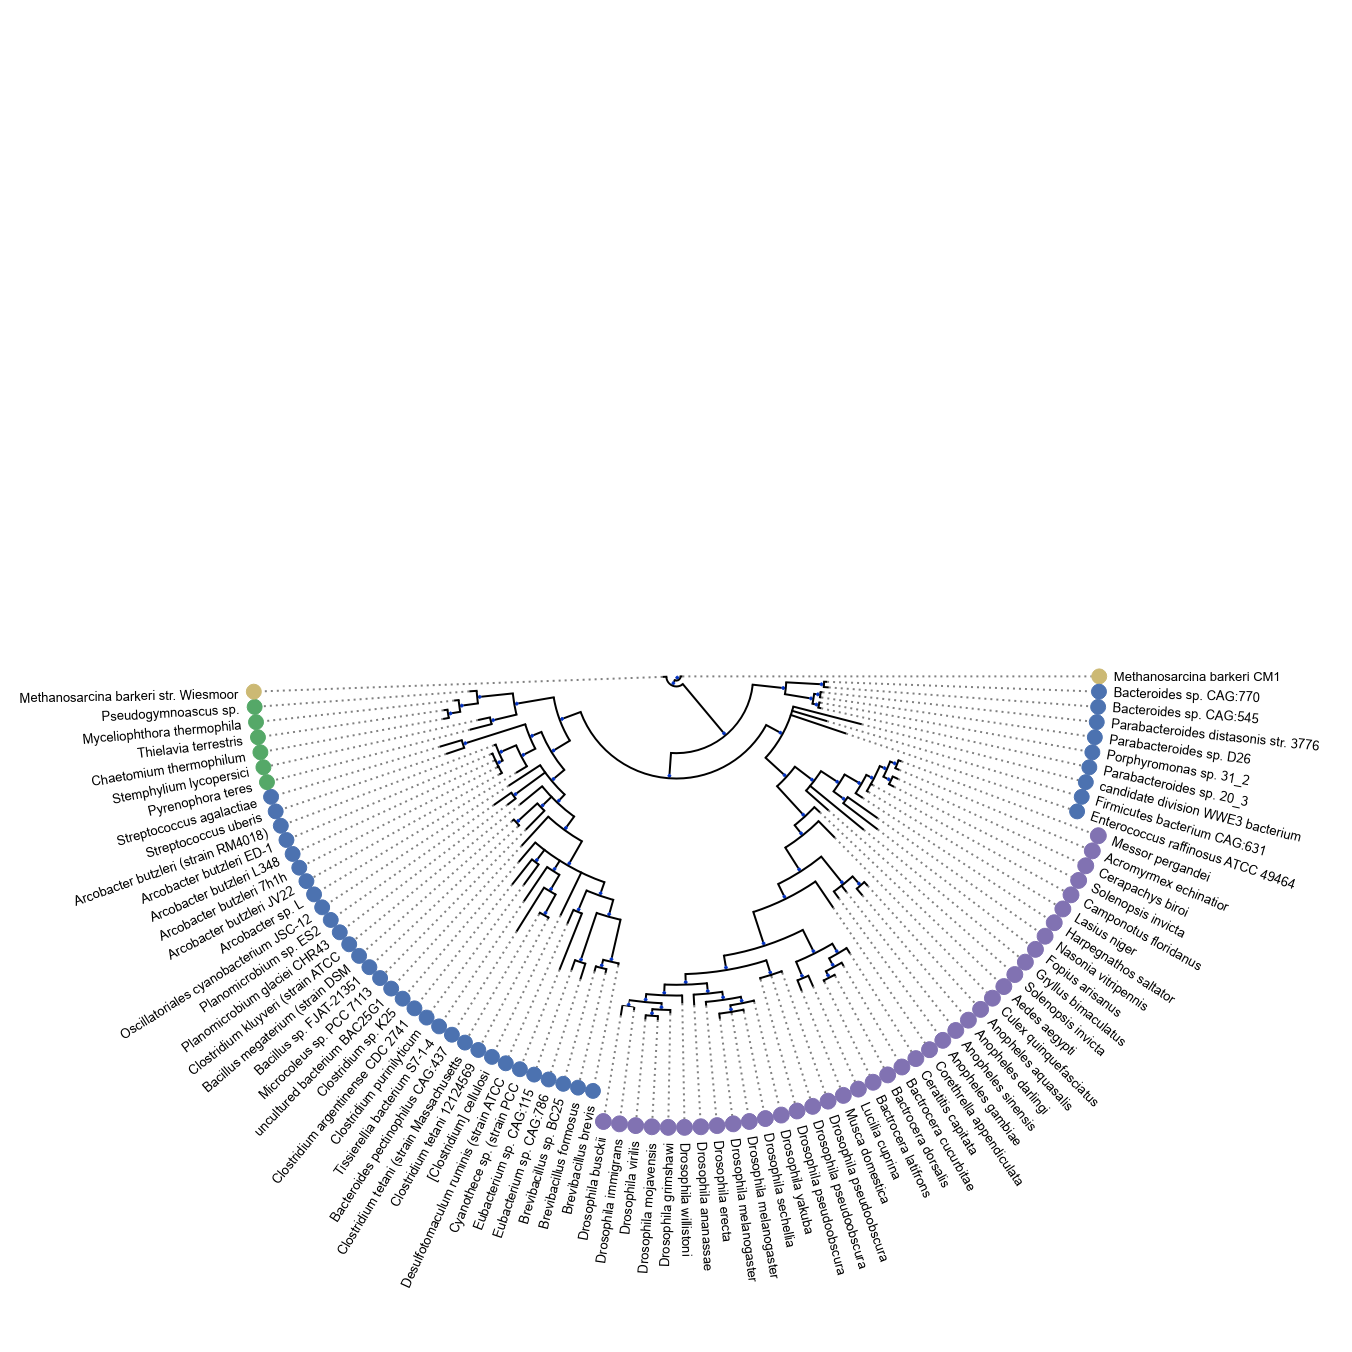

In [108]:
SGNH_Bayes_noPut.render('%%inline', tree_style=ts)
# SGNH_Bayes_noPut.render('Figure2_SGNH_Bayes_circular.pdf', tree_style=ts, units='mm', w=183, dpi=600)

# Defining Parameters for Supp Info Trees

In [109]:
ts = ete3.TreeStyle()
ts.show_branch_support = True
ts.show_scale = False
ts.show_leaf_name = True
ts.complete_branch_lines_when_necessary = True

# LOTUS Trees for Figure S1 and S2

## RaxML tree

### Creating and decorating the tree

In [110]:
LOTUS_animala = ete3.Tree(open(LOTUS_animala_path).read())
LOTUS_animala = decorate(LOTUS_animala)
for leaf in LOTUS_animala:
    if leaf.kingdom == 'B':
        LOTUS_animala.set_outgroup( leaf )
trav = LOTUS_animala.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2
for leaf in LOTUS_animala:
    leaf.name= '  '+ leaf.protid + ' | ' + leaf.specie + ' | ' + leaf.fullname

Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar


### Plotting the tree

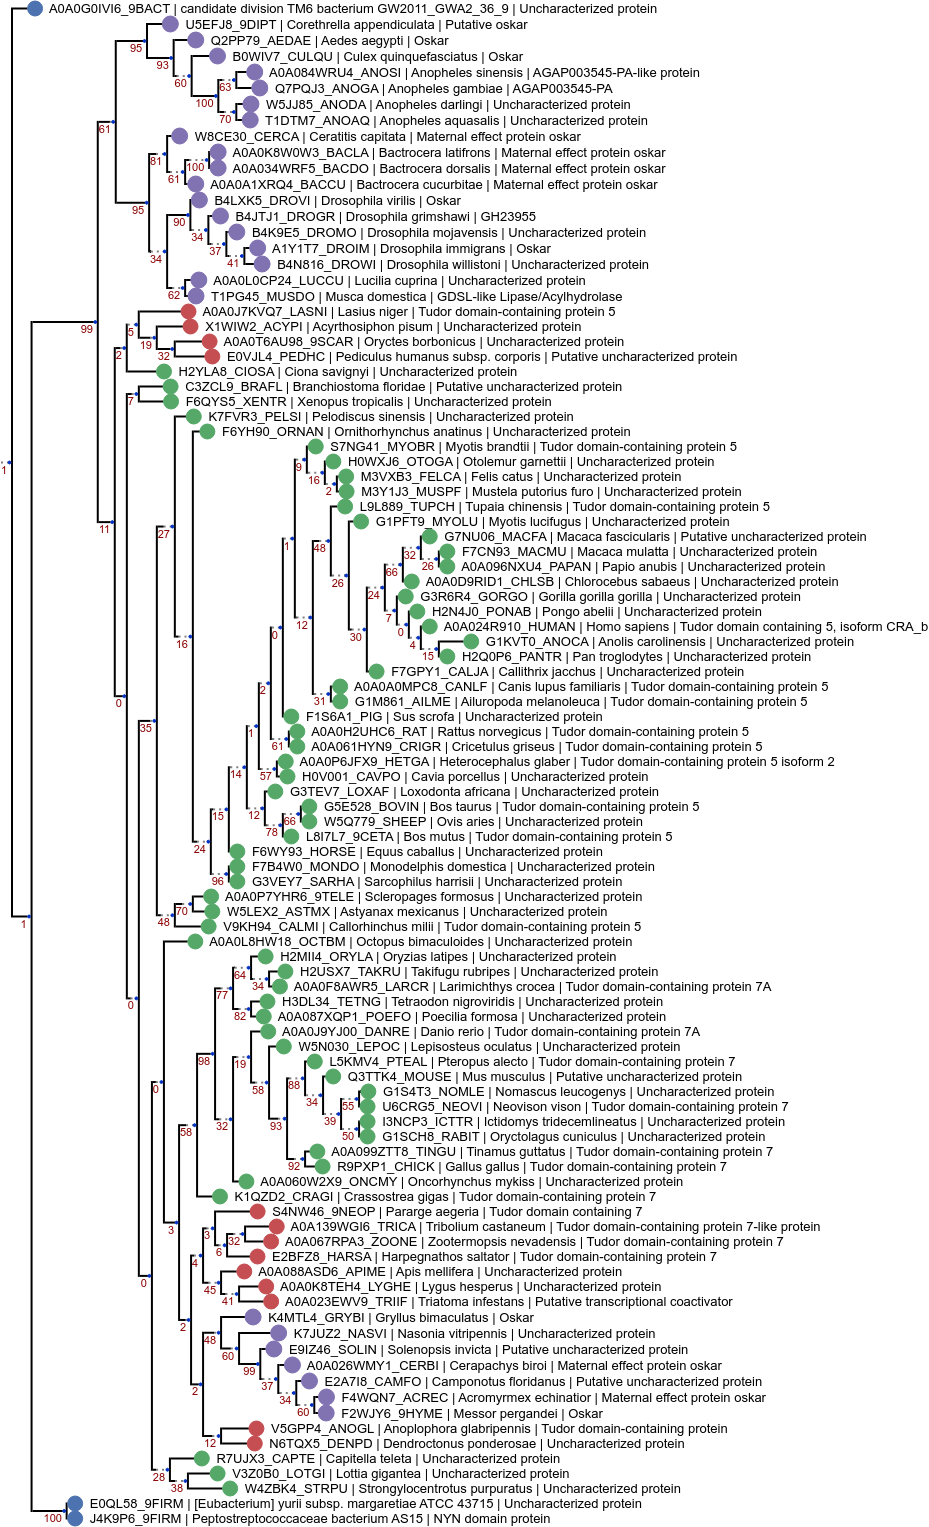

In [111]:
LOTUS_animala.render('%%inline', tree_style=ts)

In [112]:
LOTUS_animala.render('FigureS1.pdf', tree_style=ts, units='mm', h=247, dpi=600)
LOTUS_animala.render('FigureS1.png', tree_style=ts, units='mm', h=247, dpi=600)
LOTUS_animala.render('FigureS1.svg', tree_style=ts, units='mm', h=247, dpi=600)

{'faces': [[1267.962841519055,
   2202.887998967416,
   1317.635659871,
   2252.5608173193614,
   76,
   '26'],
  [861.6599120255931,
   185.31782231302554,
   2004.134734120328,
   242.6326127191159,
   10,
   '  B0WIV7_CULQU | Culex quinquefasciatus | Oskar'],
  [711.1992397523275,
   615.1787503587034,
   783.7979742667086,
   664.8515687106484,
   22,
   '100'],
  [829.6583334725009,
   1276.209333042279,
   2388.620632518159,
   1333.5241234483694,
   46,
   '  A0A0T6AU98_9SCAR | Oryctes borbonicus | Uncharacterized protein'],
  [860.1401181346231,
   5601.565515688566,
   2178.380297474702,
   5658.880306094657,
   194,
   '  V3Z0B0_LOTGI | Lottia gigantea | Uncharacterized protein'],
  [731.2231713692943,
   882.6477722537918,
   780.8959897212393,
   932.3205906057368,
   29,
   '34'],
  [821.0527470754404,
   1620.0980754788213,
   2410.58293433768,
   1677.4128658849115,
   58,
   '  F6YH90_ORNAN | Ornithorhynchus anatinus | Uncharacterized protein'],
  [778.6110007662019,
  

## Mr Bayes tree

### Decorating the tree

In [113]:
for leaf in LOTUS_bayes:
    leaf.name= '  '+ leaf.protid + ' | ' + leaf.specie + ' | ' + leaf.fullname

### Plotting the tree

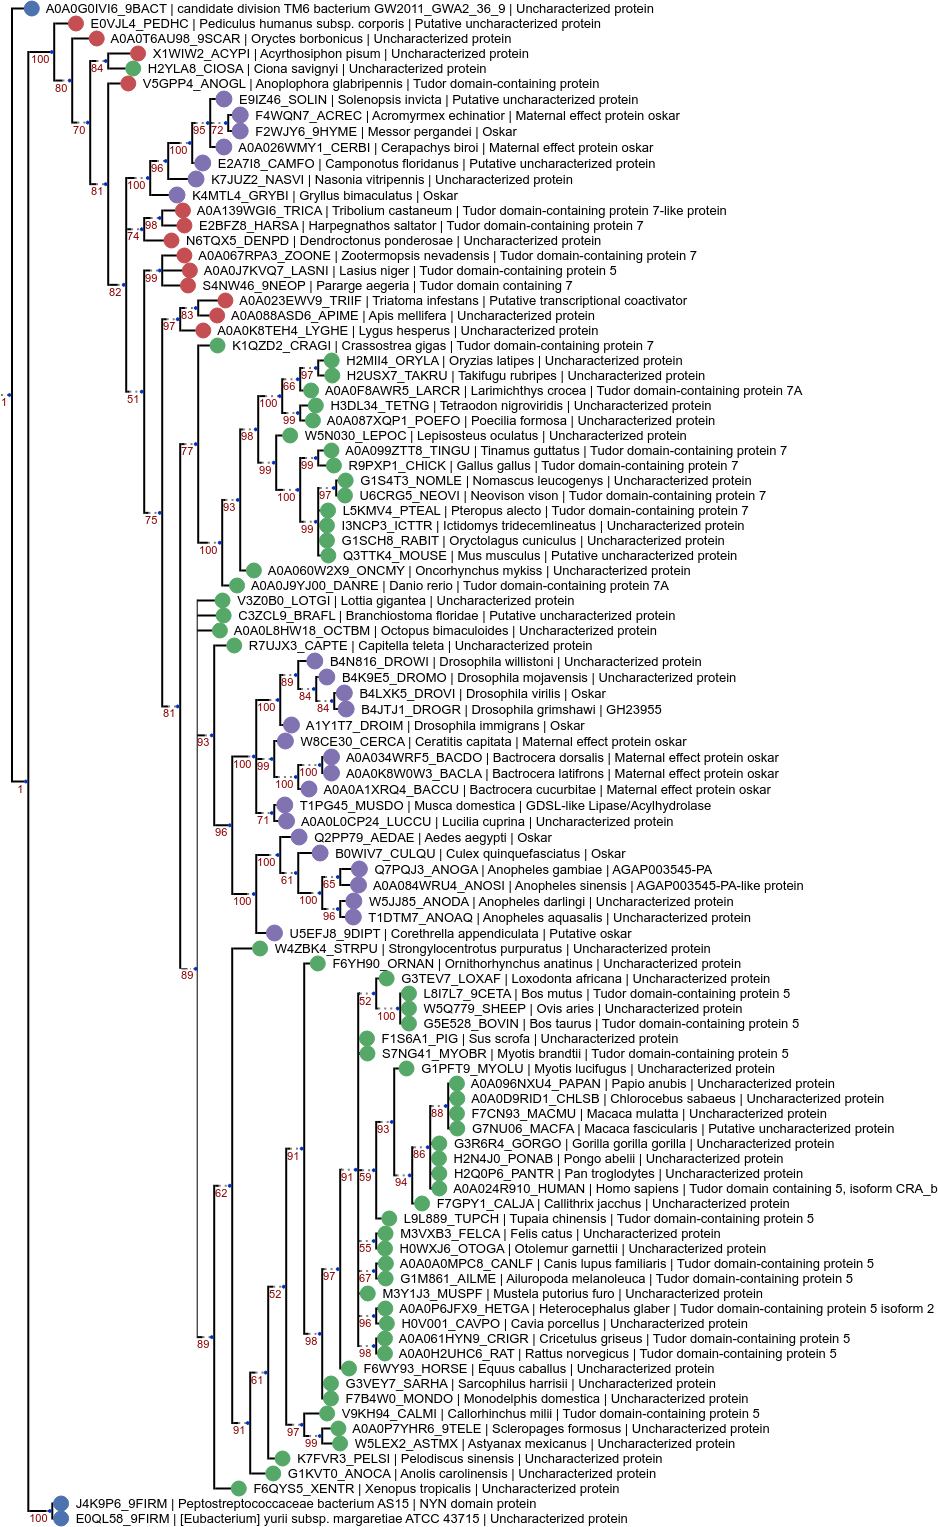

In [114]:
LOTUS_bayes.render('%%inline', tree_style=ts)

In [115]:
LOTUS_bayes.render('FigureS2.pdf', tree_style=ts, units='mm', h=247,  dpi=600)
LOTUS_bayes.render('FigureS2.png', tree_style=ts, units='mm', h=247,  dpi=600)
LOTUS_bayes.render('FigureS2.svg', tree_style=ts, units='mm', h=247,  dpi=600)

{'faces': [[683.8398219166626,
   890.2897443079371,
   2300.116911368411,
   947.6045347140275,
   30,
   '  N6TQX5_DENPD | Dendroctonus ponderosae | Uncharacterized protein'],
  [807.0203006465271,
   473.80226735701376,
   856.6931189984721,
   523.4750857089588,
   19,
   '72'],
  [1707.3221069875149,
   4512.584497972849,
   3583.426246280206,
   4569.899288378939,
   145,
   '  A0A024R910_HUMAN | Homo sapiens | Tudor domain containing 5, isoform CRA_b'],
  [959.8597417294347,
   5248.512377077716,
   1009.5325600813799,
   5298.185195429662,
   117,
   '61'],
  [1279.4906268947552,
   2558.150145125167,
   2815.5270097779776,
   2615.4649355312577,
   85,
   '  B4K9E5_DROMO | Drosophila mojavensis | Uncharacterized protein'],
  [1499.7741204189267,
   4741.843659597211,
   2928.8228945441133,
   4799.1584500033005,
   150,
   '  H0WXJ6_OTOGA | Otolemur garnettii | Uncharacterized protein'],
  [1219.6867915703779,
   1868.4621672385463,
   1269.359609922323,
   1918.1349855904912,

# OSK Trees for Figure S3 and S4

## RaxML tree

### Creating and decorating the tree

In [118]:
SGNH_RaxML_noPut = ete3.Tree(open(SGNH_RaxML_noPut_path).read())

In [119]:
SGNH_RaxML_noPut = ete3.Tree(open(SGNH_RaxML_noPut_path).read())
decorate(SGNH_RaxML_noPut, bayes=False)
for leaf in SGNH_RaxML_noPut:
    if 'milii' in leaf.name:
        SGNH_RaxML_noPut.set_outgroup( leaf )
remove_duplicate_specie(SGNH_RaxML_noPut, ar=True)
trav = SGNH_RaxML_noPut.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2
for leaf in SGNH_RaxML_noPut:
    if "candidate division" in leaf.specie:
        leaf.name = 'WWE3 bacterium'
    if leaf.kingdom == 'A':
        print(leaf)
        SGNH_RaxML_noPut.set_outgroup( leaf )
    leaf.name= '  '+ leaf.protid + ' | ' + leaf.specie + ' | ' + leaf.fullname

Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar

--Methanosarcina barkeri CM1

--Methanosarcina barkeri str. Wiesmoor


### Plotting the tree

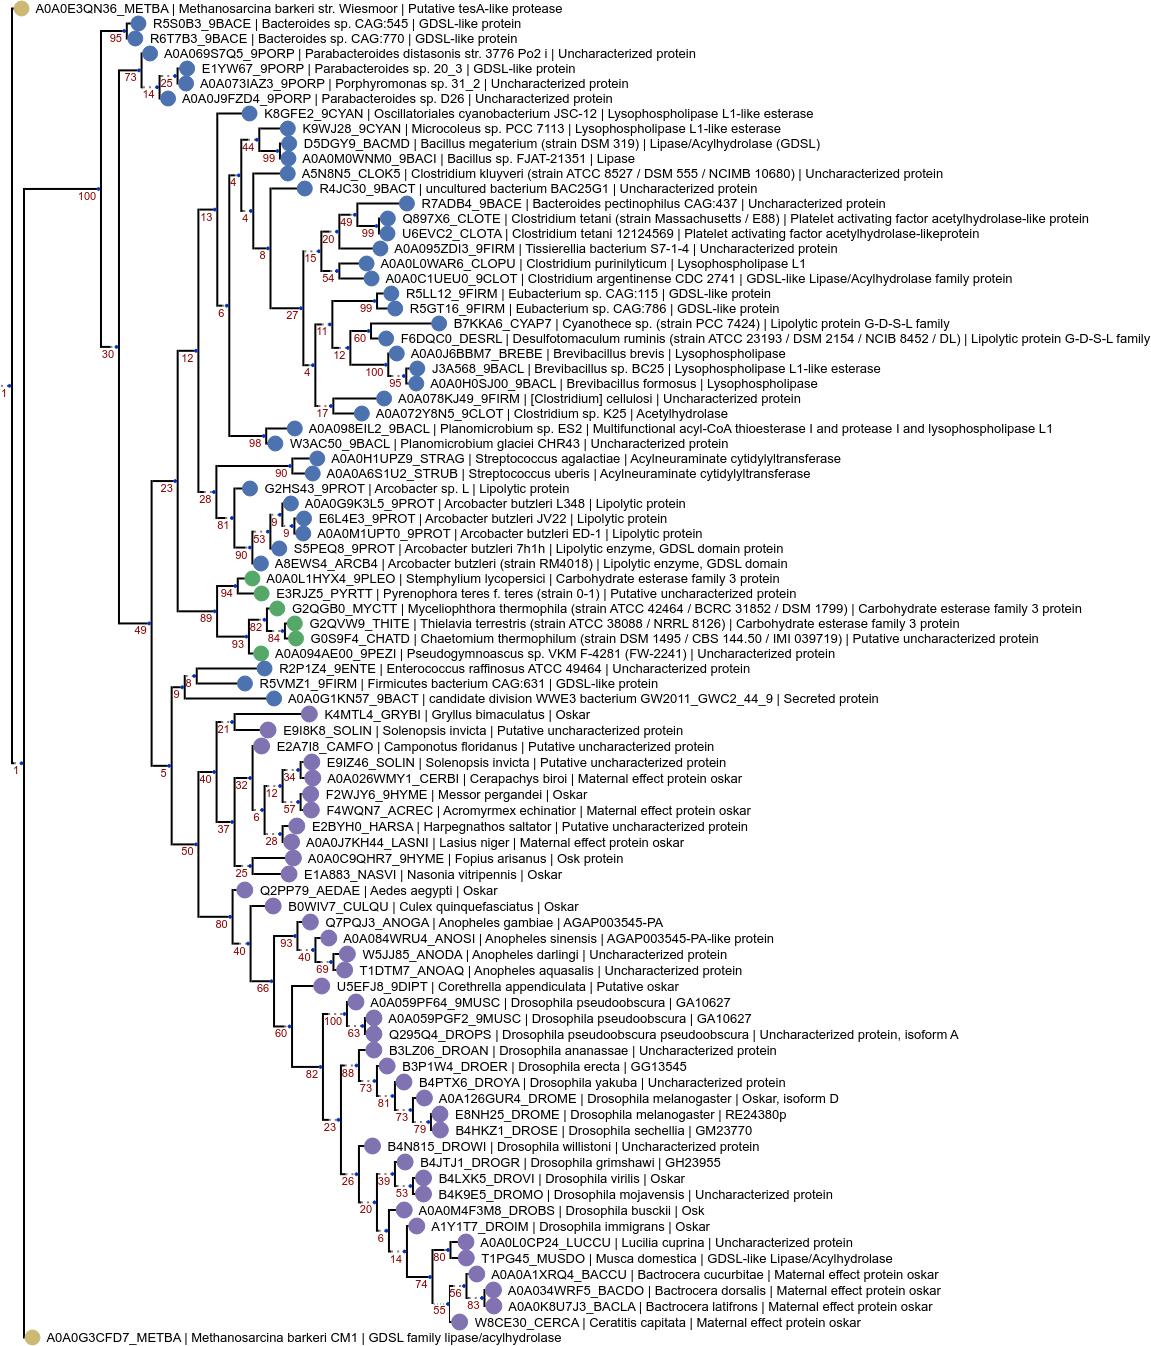

In [120]:
SGNH_RaxML_noPut.render('%%inline', tree_style=ts)

In [121]:
SGNH_RaxML_noPut.render('FigureS3.pdf', tree_style=ts, units='mm', h=247,  dpi=600)
SGNH_RaxML_noPut.render('FigureS3.png', tree_style=ts, units='mm', h=247,  dpi=600)
SGNH_RaxML_noPut.render('FigureS3.svg', tree_style=ts, units='mm', h=247,  dpi=600)

{'faces': [[943.2315007160286,
   3134.0630123289898,
   999.5839476873658,
   3190.4154593003273,
   97,
   '21'],
  [173.39230098941297,
   5765.288805529123,
   2436.1597870692644,
   5830.31085972682,
   172,
   '  A0A0G3CFD7_METBA | Methanosarcina barkeri CM1 | GDSL family lipase/acylhydrolase'],
  [2175.499669939845,
   5628.742491713961,
   4048.134830833515,
   5693.7645459116575,
   170,
   '  A0A0K8U7J3_BACLA | Bactrocera latifrons | Maternal effect protein oskar'],
  [1390.6293560274178,
   3339.96618395503,
   3224.25128440247,
   3404.988238152727,
   107,
   '  A0A026WMY1_CERBI | Cerapachys biroi | Maternal effect protein oskar'],
  [1229.328539185895,
   3342.13358576162,
   1285.6809861572322,
   3398.486032732957,
   105,
   '34'],
  [1381.269140849181,
   3409.3230417659065,
   2551.666116407725,
   3474.3450959636034,
   109,
   '  F2WJY6_9HYME | Messor pergandei | Oskar'],
  [1785.7264779913341,
   4657.7464823616865,
   3406.943029320577,
   4722.768536559383,
   1

## Bayes tree

### Decorating the tree

In [122]:
for leaf in SGNH_Bayes_noPut:
    leaf.name= '  '+ leaf.protid + ' | ' + leaf.specie + ' | ' + leaf.fullname

### Plotting the tree

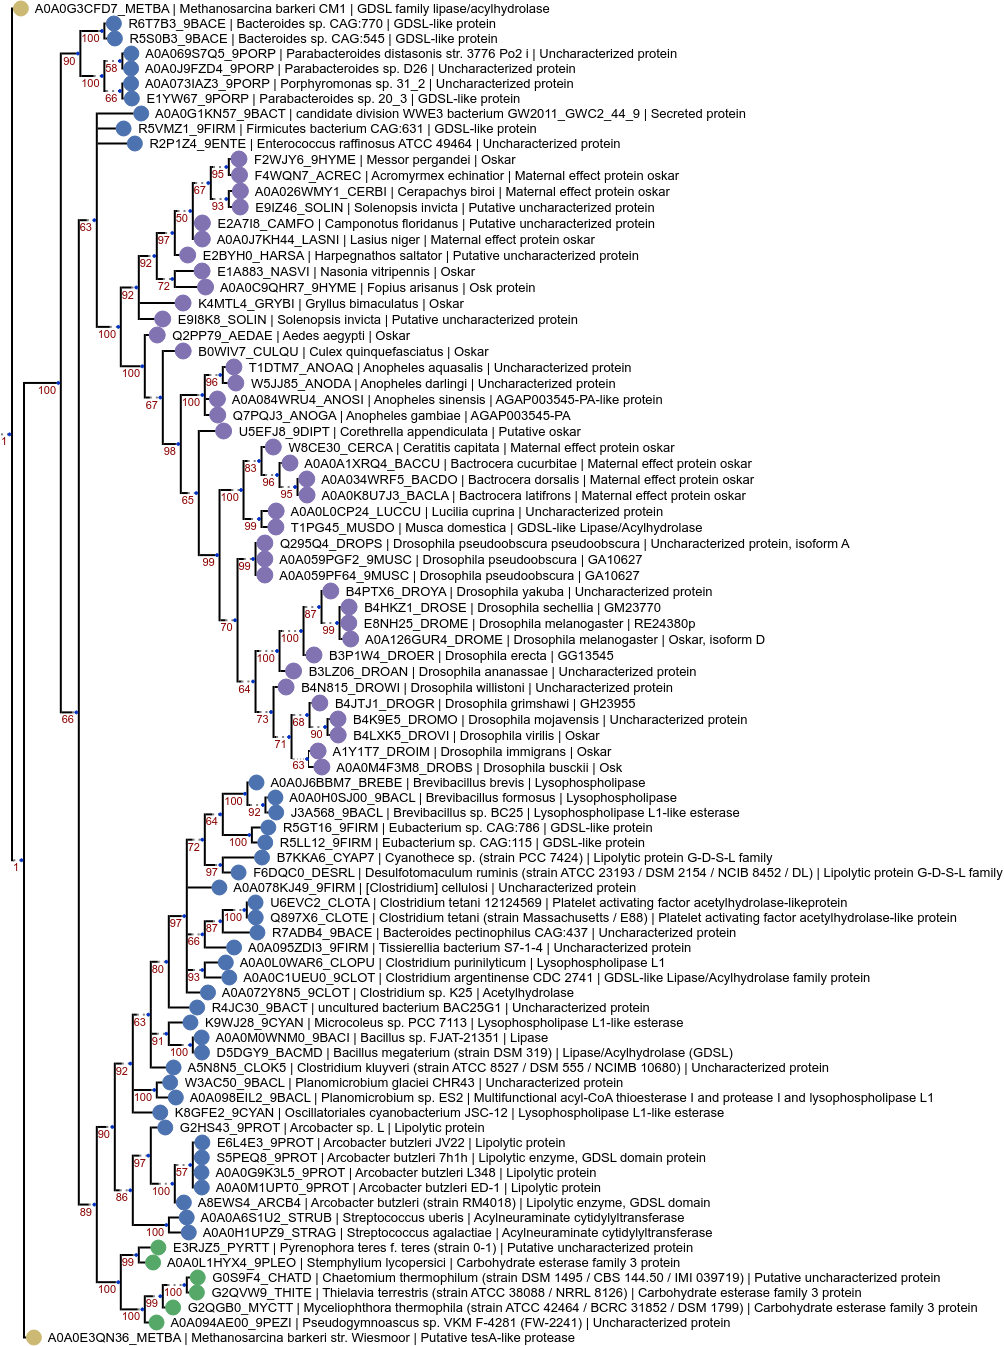

In [123]:
SGNH_Bayes_noPut.render('%%inline', tree_style=ts)

In [124]:
SGNH_Bayes_noPut.render('FigureS4.pdf', tree_style=ts, units='mm', h=247, dpi=600)
SGNH_Bayes_noPut.render('FigureS4.png', tree_style=ts, units='mm', h=247, dpi=600)
SGNH_Bayes_noPut.render('FigureS4.svg', tree_style=ts, units='mm', h=247, dpi=600)

{'faces': [[179.5499938026563,
   5765.288805529123,
   2494.3351232406653,
   5830.31085972682,
   158,
   '  A0A0E3QN36_METBA | Methanosarcina barkeri str. Wiesmoor | Putative tesA-like protease'],
  [568.2916766004678,
   524.5112371947548,
   2328.2219435514635,
   589.5332913924517,
   18,
   '  R5VMZ1_9FIRM | Firmicutes bacterium CAG:631 | GDSL-like protein'],
  [1148.5158969516385,
   4009.6933421913077,
   3194.5432023725007,
   4074.7153963890046,
   117,
   '  R7ADB4_9BACE | Bacteroides pectinophilus CAG:437 | Uncharacterized protein'],
  [710.0829119993119,
   5574.557446549213,
   792.444180649728,
   5630.90989352055,
   153,
   '100'],
  [970.1711287900995,
   3949.0060916067905,
   1052.5323974405155,
   4005.358538578128,
   114,
   '100'],
  [1144.4528468886913,
   3359.472800214339,
   2800.3478271233716,
   3424.4948544120357,
   101,
   '  A0A0J6BBM7_BREBE | Brevibacillus brevis | Lysophospholipase'],
  [892.1446637528633,
   1629.886158555602,
   948.4971107242005,

# SOWHAT trees

In [178]:
ts = ete3.TreeStyle()
ts.show_branch_support = False
ts.show_scale = False
ts.show_leaf_name = True
ts.complete_branch_lines_when_necessary = True

In [222]:
SGNH_SOWHAT_kingdom_mono = ete3.Tree(open(OSK_kingdom_sowhat).read())

In [223]:
decorate(SGNH_SOWHAT_kingdom_mono, bayes=False)
for leaf in SGNH_SOWHAT_kingdom_mono:
    if 'milii' in leaf.name:
        SGNH_SOWHAT_kingdom_mono.set_outgroup( leaf )
remove_duplicate_specie(SGNH_SOWHAT_kingdom_mono, ar=True)
trav = SGNH_SOWHAT_kingdom_mono.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2
for leaf in SGNH_SOWHAT_kingdom_mono:
    if "candidate division" in leaf.specie:
        leaf.name = 'WWE3 bacterium'
    if leaf.kingdom == 'A':
        print(leaf)
        SGNH_SOWHAT_kingdom_mono.set_outgroup( leaf )
    leaf.name= '  '+ leaf.protid + ' | ' + leaf.specie + ' | ' + leaf.fullname

Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar

--Methanosarcina barkeri str. Wiesmoor

--Methanosarcina barkeri CM1


### Plotting the tree

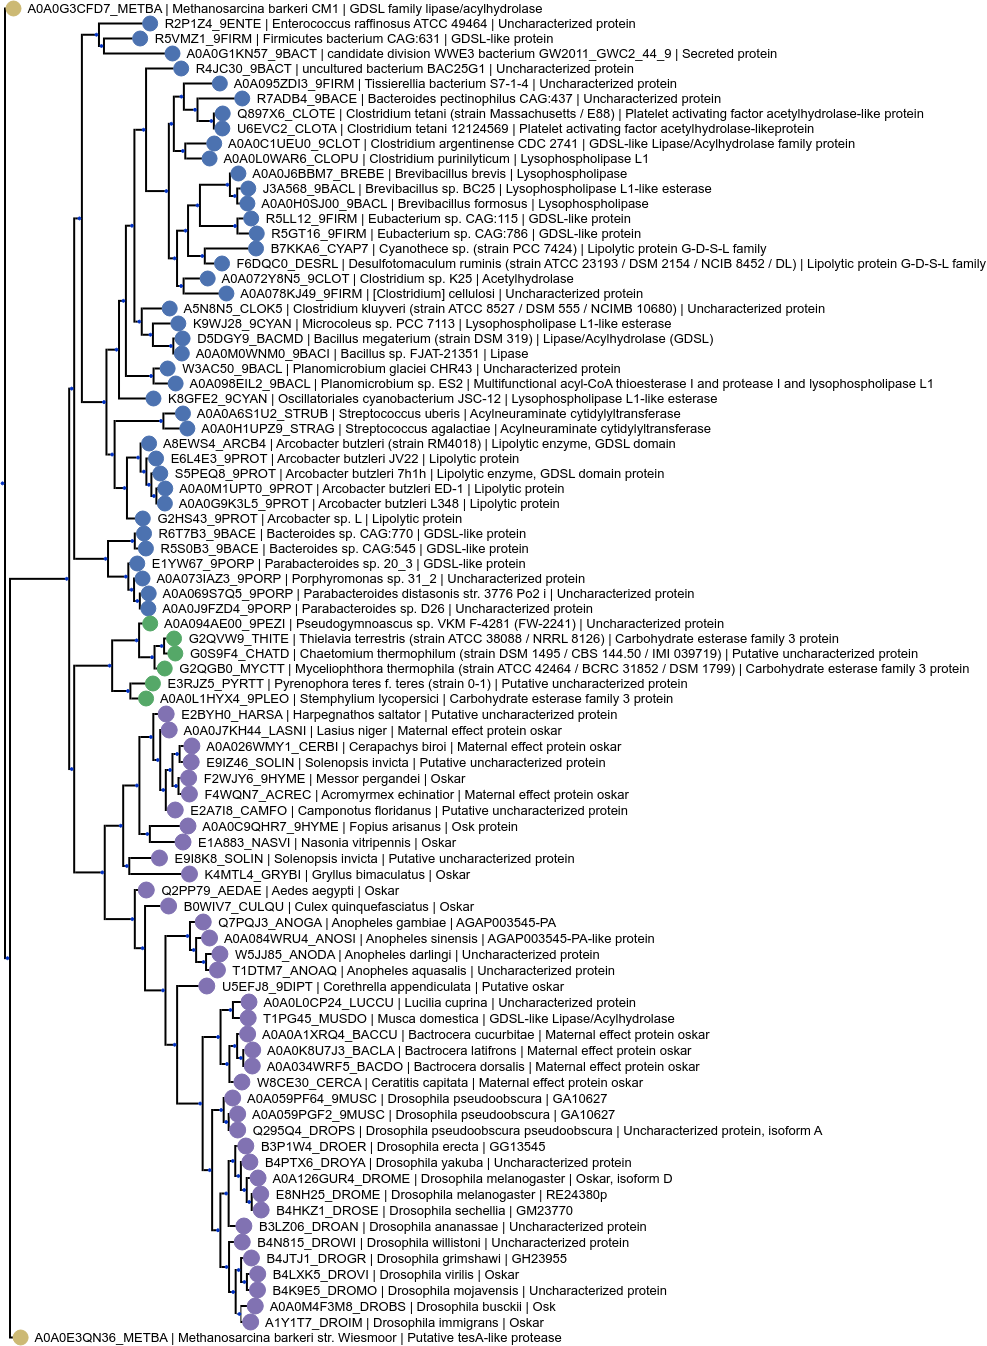

In [224]:
SGNH_SOWHAT_kingdom_mono.render('%%inline', tree_style=ts)

In [225]:
SGNH_SOWHAT_kingdom_mono.render('FigureS7.pdf', tree_style=ts, units='mm', h=247,  dpi=600)
SGNH_SOWHAT_kingdom_mono.render('FigureS7.png', tree_style=ts, units='mm', h=247,  dpi=600)
SGNH_SOWHAT_kingdom_mono.render('FigureS7.svg', tree_style=ts, units='mm', h=247,  dpi=600)

{'faces': [[1121.2523967567395,
   5698.099349524837,
   2365.3410337393398,
   5763.121403722534,
   171,
   '  A1Y1T7_DROIM | Drosophila immigrans | Oskar'],
  [863.473293893876,
   3270.6093261441533,
   2627.738364458051,
   3335.63138034185,
   106,
   '  E9IZ46_SOLIN | Solenopsis invicta | Putative uncharacterized protein'],
  [855.7811855220036,
   3409.3230417659065,
   2732.7511500288533,
   3474.3450959636034,
   109,
   '  F4WQN7_ACREC | Acromyrmex echinatior | Maternal effect protein oskar'],
  [988.0420461118777,
   4102.891619874674,
   2600.58899021476,
   4167.913674072371,
   127,
   '  W5JJ85_ANODA | Anopheles darlingi | Uncharacterized protein'],
  [985.487180294809,
   329.4450746016642,
   2936.148806225715,
   394.4671287993611,
   20,
   '  A0A095ZDI3_9FIRM | Tissierellia bacterium S7-1-4 | Uncharacterized protein'],
  [1141.2021325556977,
   5628.742491713961,
   2411.2995912173765,
   5693.7645459116575,
   170,
   '  A0A0M4F3M8_DROBS | Drosophila busckii | Osk

## Eukaryote as a monophyly

In [226]:
SGNH_SOWHAT_euk_mono = ete3.Tree(open(OSK_eukmono_sowhat).read())

In [219]:
decorate(SGNH_SOWHAT_euk_mono, bayes=False)
for leaf in SGNH_SOWHAT_euk_mono:
    if 'milii' in leaf.name:
        SGNH_SOWHAT_euk_mono.set_outgroup( leaf )
remove_duplicate_specie(SGNH_SOWHAT_euk_mono, ar=True)
trav = SGNH_SOWHAT_euk_mono.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2
for leaf in SGNH_SOWHAT_euk_mono:
    if "candidate division" in leaf.specie:
        leaf.name = 'WWE3 bacterium'
    if leaf.kingdom == 'A':
        print(leaf)
        SGNH_SOWHAT_euk_mono.set_outgroup( leaf )
    leaf.name= '  '+ leaf.protid + ' | ' + leaf.specie + ' | ' + leaf.fullname

Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar
Testing if oskar

--Methanosarcina barkeri str. Wiesmoor

--Methanosarcina barkeri CM1


### Plotting the tree

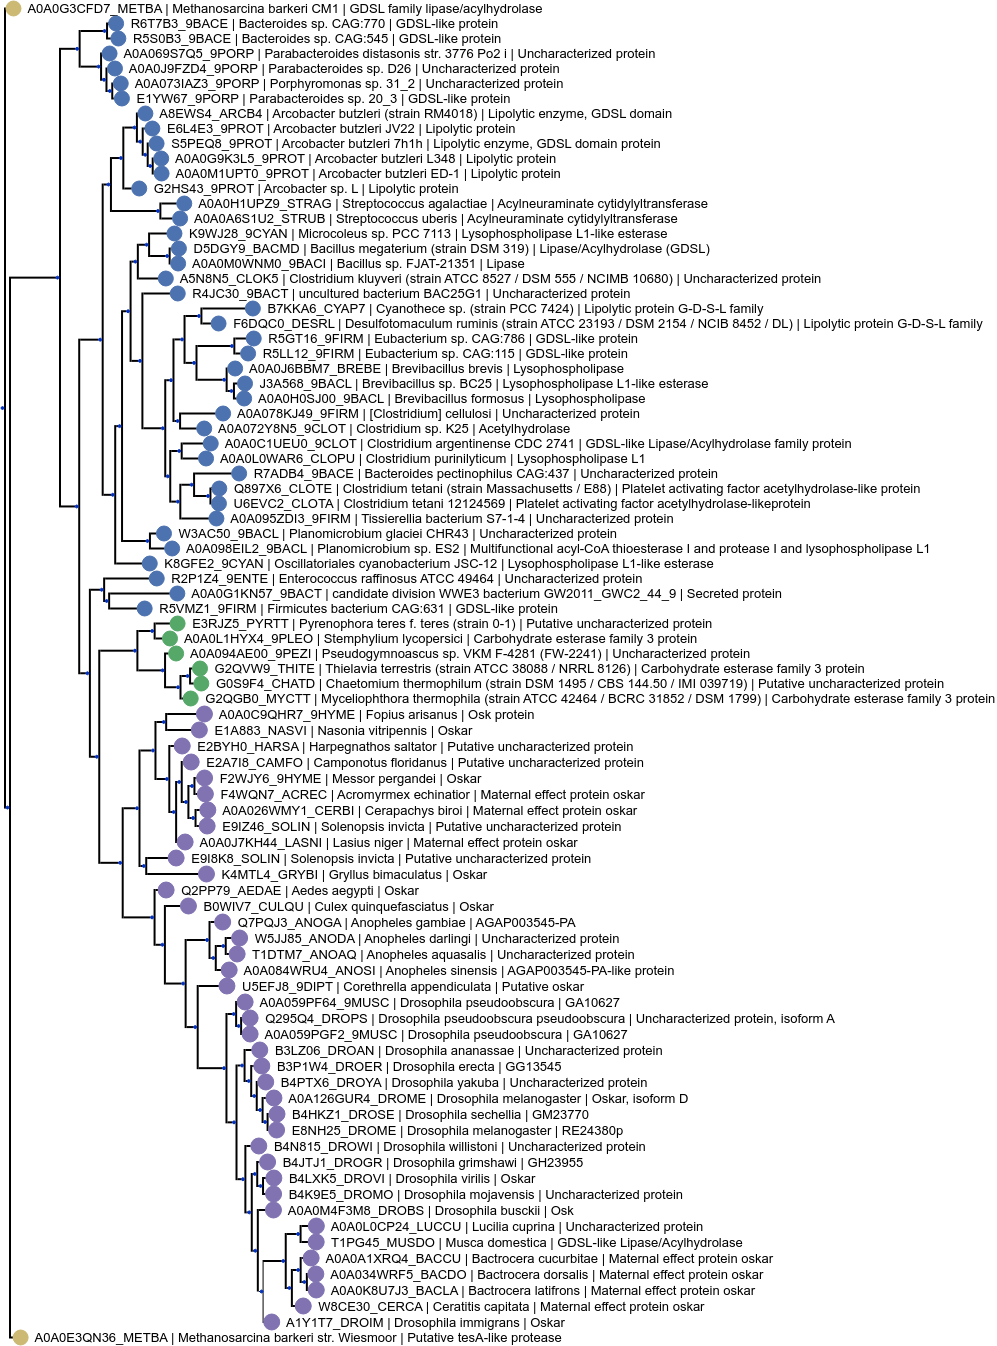

In [220]:
SGNH_SOWHAT_euk_mono.render('%%inline', tree_style=ts)

In [221]:
SGNH_SOWHAT_euk_mono.render('FigureS8.pdf', tree_style=ts, units='mm', h=247,  dpi=600)
SGNH_SOWHAT_euk_mono.render('FigureS8.png', tree_style=ts, units='mm', h=247,  dpi=600)
SGNH_SOWHAT_euk_mono.render('FigureS8.svg', tree_style=ts, units='mm', h=247,  dpi=600)

{'faces': [[1118.9191591728093,
   4449.675908929056,
   2722.7964960493323,
   4514.697963126753,
   136,
   '  A0A059PGF2_9MUSC | Drosophila pseudoobscura | GA10627'],
  [831.3328871858994,
   849.6215081832393,
   3072.426355199852,
   914.6435623809361,
   30,
   '  A0A0H1UPZ9_STRAG | Streptococcus agalactiae | Acylneuraminate cytidylyltransferase'],
  [946.0805137157756,
   1889.9743753463895,
   3694.3460044717635,
   1954.9964295440864,
   64,
   '  A0A0C1UEU0_9CLOT | Clostridium argentinense CDC 2741 | GDSL-like Lipase/Acylhydrolase family protein'],
  [804.6898448371189,
   1109.7097249740268,
   2278.5230733182484,
   1174.7317791717237,
   40,
   '  A0A0M0WNM0_9BACI | Bacillus sp. FJAT-21351 | Lipase'],
  [1405.9485299328026,
   5281.958202659577,
   3053.1739029411237,
   5346.980256857274,
   162,
   '  A0A0L0CP24_LUCCU | Lucilia cuprina | Uncharacterized protein'],
  [813.2225991977866,
   914.6435623809361,
   2941.6111732690647,
   979.665616578633,
   31,
   '  A0A0A6S

### Schematics of constrain

In [207]:
Kindgom = "((Bacterias, Bacterias),(OSK, Eukaryotes), Archeas);"

In [208]:
t = ete3.Tree(Kindgom)

In [209]:
trav = t.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2

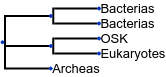

In [210]:
t.render('%%inline', tree_style=ts)

In [211]:
EukMono = "(Bacterias, Bacterias, Archeas,(OSK, Eukaryotes));"

In [212]:
t = ete3.Tree(EukMono)

In [213]:
trav = t.traverse()
for node in trav:
    node.img_style['hz_line_width'] = 2
    node.img_style['vt_line_width'] = 2

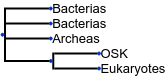

In [214]:
t.render('%%inline', tree_style=ts)

In [215]:
OSK = "(Archeas,(Bacterias, (Bacterias, OSK), (Bacterias, Eukaryotes)));"

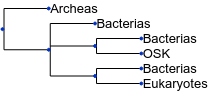

In [216]:
t = ete3.Tree(OSK)
t.render('%%inline', tree_style=ts)

In [217]:
pwd

'/home/lblondel/Dropbox/Cassandra and Leo/HGT Paper/181108 SUBMISSION Science/HGT 181025 Individual Components for Science Submission/Blondel_Jones_Extavour_HGT_Supplementary Information Files/Scripts/notebook'